# Chicago Park District Event Permits - EDA and Geocoding

This notebook performs exploratory data analysis and converts Park/Facility names to latitude and longitude coordinates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time
from tqdm import tqdm
import warnings
import os
from openai import OpenAI
from dotenv import load_dotenv
warnings.filterwarnings('ignore')

# Load environment variables from .env file
# Try to find .env file in common locations:
# 1. Parent directory (where .env is likely located: datasets/events/)
env_path = os.path.join('..', '.env')
if not os.path.exists(env_path):
    # 2. Current working directory
    env_path = os.path.join(os.getcwd(), '.env')
if not os.path.exists(env_path):
    # 3. Root of the repo (datasets/events/)
    env_path = '.env'
# Load .env file if it exists
if os.path.exists(env_path):
    load_dotenv(env_path, override=True)
    print(f"Loaded .env from: {os.path.abspath(env_path)}")
else:
    print("Warning: .env file not found. Looking for OPENAI_API_KEY in environment variables.")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize OpenAI client (get API key from .env file)
openai_client = None
api_key = os.getenv('OPENAI_API_KEY')
if api_key:
    openai_client = OpenAI(api_key=api_key)
    print("OpenAI client initialized successfully from .env file")
else:
    print("Warning: OPENAI_API_KEY not found in .env file. GPT fallback will be unavailable.")


Loaded .env from: /home/mahdi/Projects/UrbanPulse/datasets/events/.env
OpenAI client initialized successfully from .env file


## 1. Load and Explore the Dataset


In [2]:
# Load the dataset
df = pd.read_csv('../Chicago_Park_District_-_Event_Permits.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (133799, 9)

Columns: ['Requestor', 'Organization', 'Park Number', 'Park/Facility Name', 'Reservation Start Date', 'Reservation End Date', 'Event Type', 'Event Description', 'Permit Status']

First few rows:


,Requestor,Organization,Park Number,Park/Facility Name,Reservation Start Date,Reservation End Date,Event Type,Event Description,Permit Status
0,Esteban Arriaga,--,24.0,Grant Lower Hutchinson Diamond 10,09/12/2024,09/12/2024,Administrative Reservation - Internal Hold PARKS,esteban,Tentative
1,Michelle Baldwin Welles Park,--,110.0,Welles Grove 03,07/30/2017,07/30/2017,Administrative Reservation - Internal Hold PARKS,Welles Nature Play Area Construction,Approved
2,Martina Brkljacic,--,123.0,Riis Picnic Grove 1,06/05/2024,06/05/2024,Permit - Event 2 Cluster 1,HSA Belmont Kindergarten Promotion Ceremony (N...,On Hold
3,Allie Fabris,--,1074.0,Wrightwood Picnic Grove Greenview-Wright,05/30/2024,05/30/2024,Permit - Event 1 Cluster 2,SJS Picnic (Non-exclusive Use),On Hold
4,Michelle Baldwin Welles Park,--,110.0,Welles Pool,06/30/2015,06/30/2015,Administrative Reservation - Internal Hold PARKS,Day Camp at Welles,Approved


In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133799 entries, 0 to 133798
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Requestor               133799 non-null  object 
 1   Organization            133799 non-null  object 
 2   Park Number             133749 non-null  float64
 3   Park/Facility Name      133799 non-null  object 
 4   Reservation Start Date  133799 non-null  object 
 5   Reservation End Date    133799 non-null  object 
 6   Event Type              133799 non-null  object 
 7   Event Description       133799 non-null  object 
 8   Permit Status           133799 non-null  object 
dtypes: float64(1), object(8)
memory usage: 9.2+ MB
None


Missing Values:
Requestor                  0
Organization               0
Park Number               50
Park/Facility Name         0
Reservation Start Date     0
Reservation End Date       0
Event Type                 0
Even

## 2. Exploratory Data Analysis


In [4]:
# Explore unique Park/Facility names
print(f"Total unique Park/Facility names: {df['Park/Facility Name'].nunique()}")
print(f"\nTop 20 most frequent Park/Facility names:")
park_facility_counts = df['Park/Facility Name'].value_counts().head(20)
print(park_facility_counts)


Total unique Park/Facility names: 2512

Top 20 most frequent Park/Facility names:
Park/Facility Name
Garfield Conservatory All Show Rooms      4987
Lakeshore East Park                       3398
Lincoln Conservatory All Show Rooms       2130
Lincoln Harbor - Diversey Event Space     2071
Oz Picnic Grove 1                         1981
Mary Bartelme Park - NE Corner of Park    1799
Lincoln Ben Franklin Statue               1616
Lincoln Picnic Grove 16                   1448
31st St. Harbor                           1376
Lincoln LaSalle/Clark/Stockton            1370
Lincoln Picnic Grove 03                   1238
Mary Bartelme Park Lawn                   1212
Lincoln Harbor - Belmont Event Space      1002
North Ave Beach                            965
Lincoln Picnic Grove 02                    947
Lincoln Picnic Grove 15                    910
Grant Buckingham Fountain                  899
Grant Butler Field                         827
Jackson Osaka Garden                       824
Hamlin

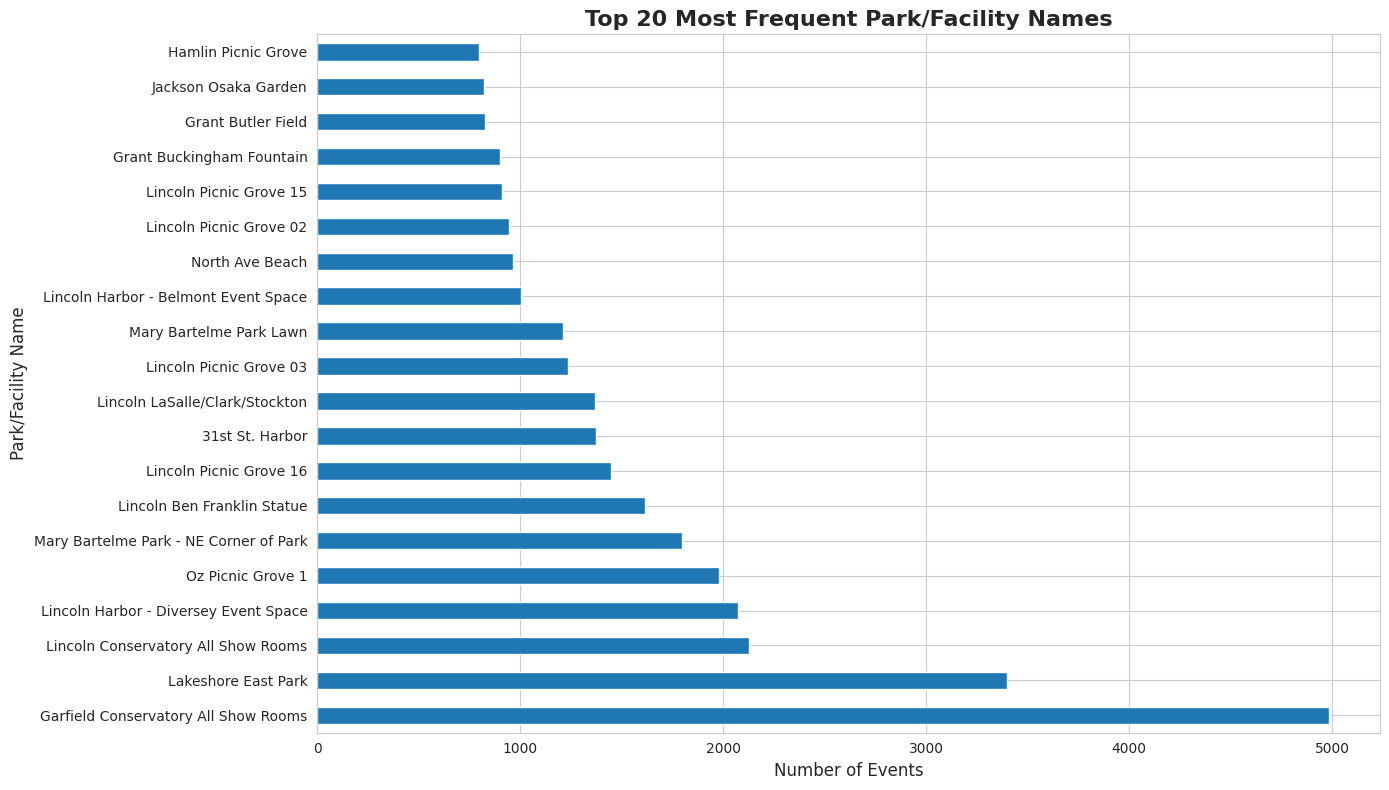

In [5]:
# Visualize top Park/Facility names
plt.figure(figsize=(14, 8))
park_facility_counts.head(20).plot(kind='barh')
plt.title('Top 20 Most Frequent Park/Facility Names', fontsize=16, fontweight='bold')
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Park/Facility Name', fontsize=12)
plt.tight_layout()
plt.show()


Event Type Distribution:
Event Type
Permit - Athletic Training                            31804
Administrative Reservation - Internal Hold PARKS      23119
Administrative Reservation - Internal Hold REVENUE     7857
Permit - Athletic T Cluster 3                          7233
Permit - Festival/Performance/12,001+ Event            5603
                                                      ...  
Permit - 2 Hour Commemorative Cluster 2                  30
Permit - 2 Hour Commemorative Cluster 1                  23
Permit - Parking Lot Rental                              22
Permit - 4 Hour Commemorative Cluster 2                  14
Permit - 4 Hour Commemorative Cluster 1                   9
Name: count, Length: 62, dtype: int64


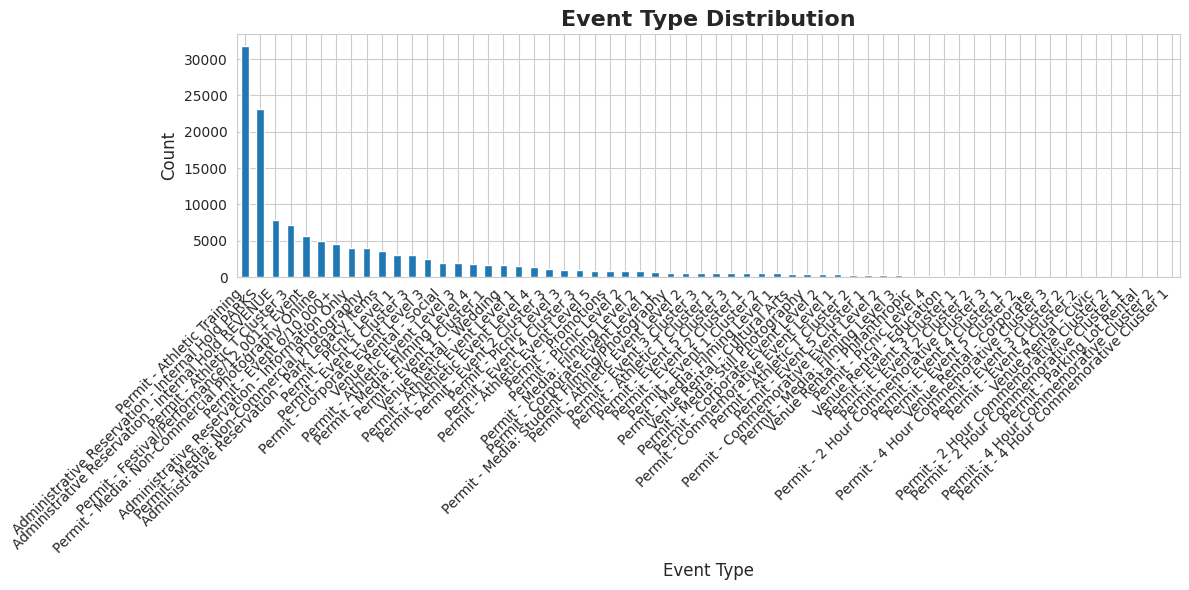

In [6]:
# Analyze Event Types
print("Event Type Distribution:")
event_type_counts = df['Event Type'].value_counts()
print(event_type_counts)

plt.figure(figsize=(12, 6))
event_type_counts.plot(kind='bar')
plt.title('Event Type Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Permit Status Distribution:
Permit Status
Approved            118598
Tentative            14827
On Hold                268
Completed               47
Waiting Decision        30
Issued                  16
Stage Denied            13
Name: count, dtype: int64


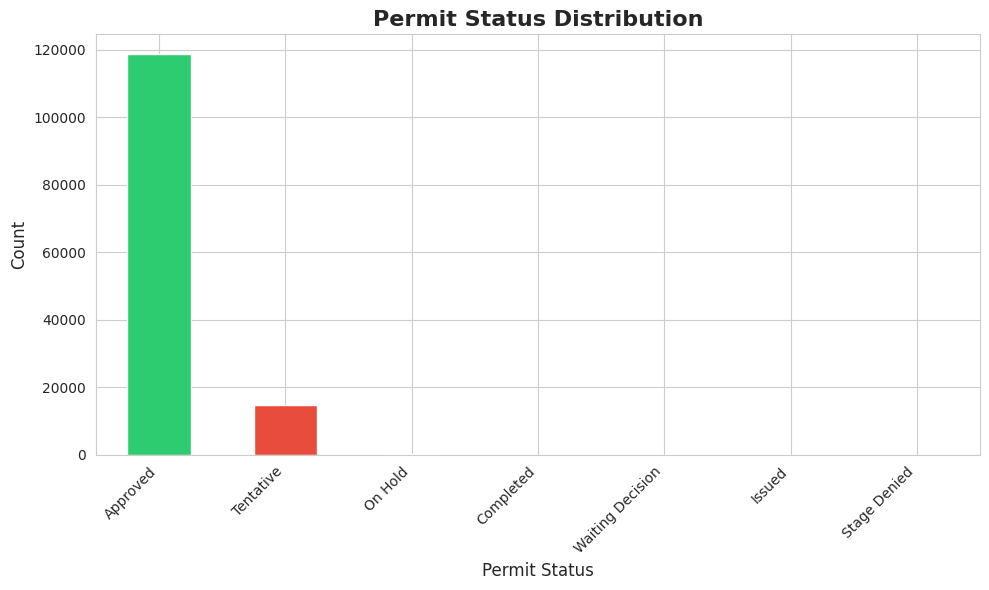

In [7]:
# Analyze Permit Status
print("Permit Status Distribution:")
status_counts = df['Permit Status'].value_counts()
print(status_counts)

plt.figure(figsize=(10, 6))
status_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#f39c12'])
plt.title('Permit Status Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Permit Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Date range: 2012-01-07 00:00:00 to 2025-12-31 00:00:00


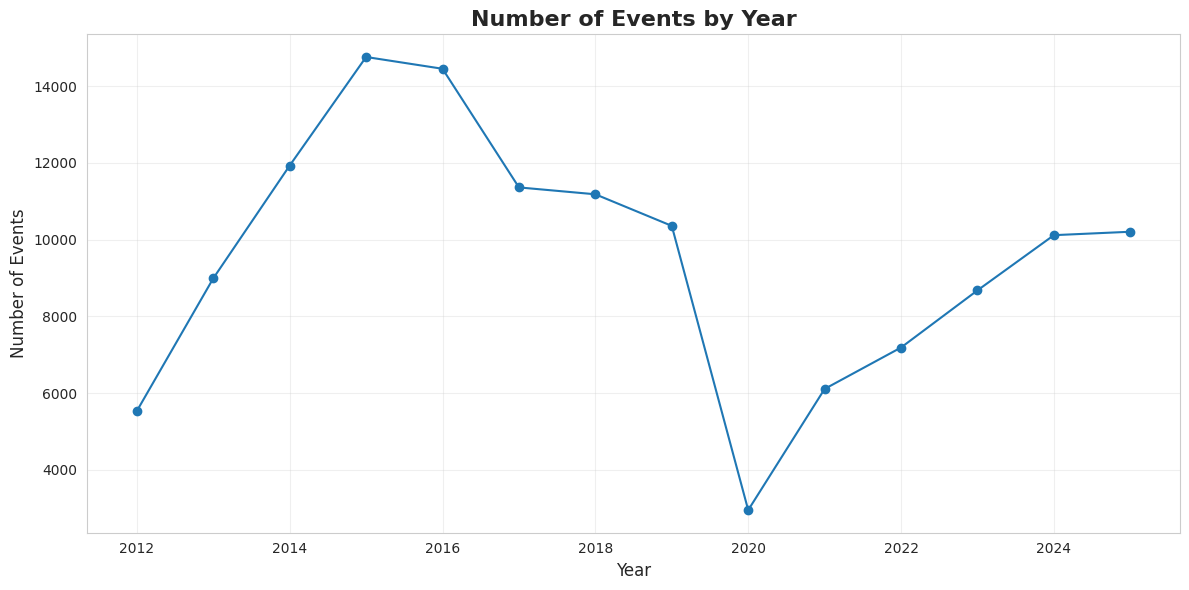

In [8]:
# Analyze dates
df['Reservation Start Date'] = pd.to_datetime(df['Reservation Start Date'], format='%m/%d/%Y', errors='coerce')
df['Reservation End Date'] = pd.to_datetime(df['Reservation End Date'], format='%m/%d/%Y', errors='coerce')

print(f"Date range: {df['Reservation Start Date'].min()} to {df['Reservation Start Date'].max()}")

# Events by year
df['Year'] = df['Reservation Start Date'].dt.year
events_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
events_by_year.plot(kind='line', marker='o')
plt.title('Number of Events by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


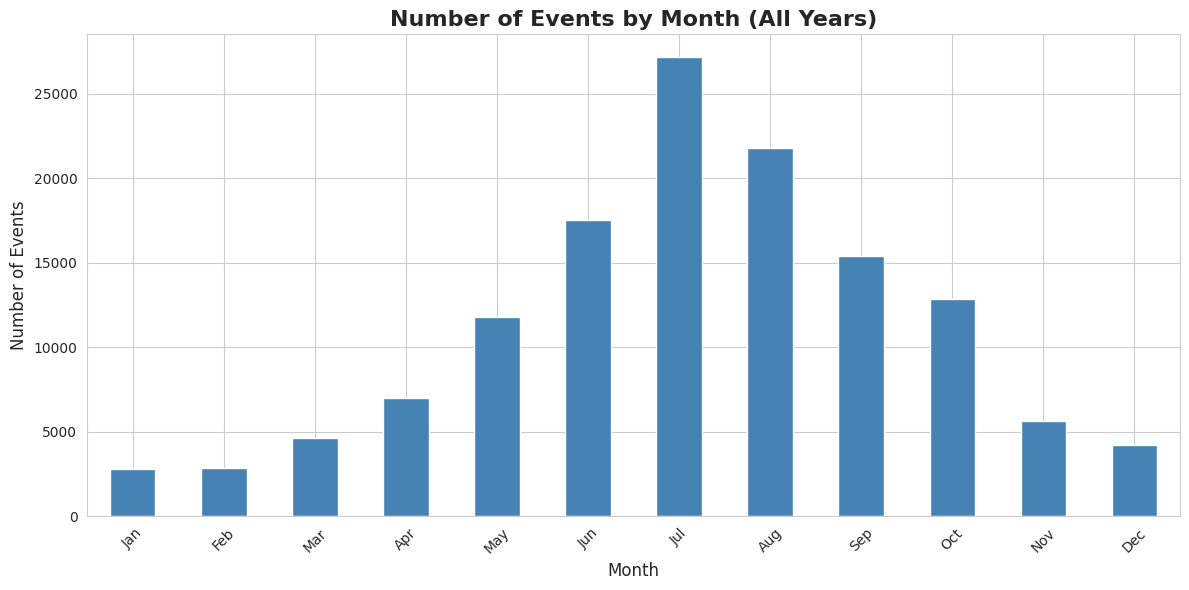

In [9]:
# Events by month (all years combined)
df['Month'] = df['Reservation Start Date'].dt.month
events_by_month = df['Month'].value_counts().sort_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
events_by_month.plot(kind='bar', color='steelblue')
plt.title('Number of Events by Month (All Years)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(range(12), month_names, rotation=45)
plt.tight_layout()
plt.show()


## 3. Geocoding Park/Facility Names to Latitude and Longitude


In [10]:
# Initialize geocoder
geolocator = Nominatim(user_agent="chicago_park_district_geocoding")

def extract_park_name_with_gpt(facility_name, park_number=None):
    """
    Use OpenAI GPT to extract the park name from a facility name.
    This is used as a fallback when regex-based extraction fails.
    """
    if not openai_client:
        return None
    
    # Build prompt with context
    context = f"""
You are helping to extract the main park name from Chicago Park District facility names.
Facility names often include the park name followed by specific facility details (like "Grove 03", "Tennis Ct02", "Picnic Grove", etc.).

Examples:
- "Grant Lower Hutchinson Diamond 10" -> "Grant Park"
- "Welles Grove 03" -> "Welles Park"
- "Riis Picnic Grove 1" -> "Riis Park"
- "McFetridge Tennis Ct02" -> "McFetridge Park"
- "Clark (Richard) Boat Launch" -> "Clark Park" or "Richard Clark Park"
- "North Ave Beach" -> "North Avenue Beach" or "North Avenue Beach Park"

Facility Name: "{facility_name}"
"""
    if park_number:
        context += f"Park Number: {park_number}\n"
    
    context += """
Extract ONLY the main park name. Return just the park name, nothing else.
If you're not sure, return the first meaningful word or two from the facility name that likely represents the park.
Return only the park name, no explanation, no quotes, just the name.
"""
    
    try:
        response = openai_client.chat.completions.create(
            model="gpt-4o",  # Using gpt-4o (most capable available model)
            messages=[
                {"role": "system", "content": "You are a helpful assistant that extracts park names from facility names."},
                {"role": "user", "content": context}
            ],
            max_tokens=50,
            temperature=0.3
        )
        park_name = response.choices[0].message.content.strip().strip('"').strip("'")
        return park_name
    except Exception as e:
        print(f"Error calling OpenAI: {e}")
        return None

def extract_park_name(facility_name):
    """
    Extract base park name from facility name.
    Handles patterns like:
    - "Grant Lower Hutchinson Diamond 10" -> "Grant"
    - "Welles Grove 03" -> "Welles"
    - "Riis Picnic Grove 1" -> "Riis"
    - "McFetridge Tennis Ct02" -> "McFetridge"
    """
    # Remove common facility suffixes/patterns
    import re
    
    # Patterns to remove: numbers, "Grove", "Picnic Grove", "Tennis Ct", "Diamond", etc.
    name = facility_name
    
    # Remove trailing numbers and spaces (e.g., "Grove 03", "Diamond 10")
    name = re.sub(r'\s+\d+$', '', name)
    name = re.sub(r'\s+[A-Z]\d+$', '', name)  # e.g., "Ct02"
    
    # Remove common facility type suffixes
    suffixes_to_remove = [
        r'\s+Lower\s+.*',  # "Lower Hutchinson Diamond"
        r'\s+Upper\s+.*',
        r'\s+Grove\s+\d+',
        r'\s+Picnic\s+Grove.*',
        r'\s+Tennis\s+Ct.*',
        r'\s+Diamond\s+\d+',
        r'\s+Field\s+\d+',
        r'\s+Playground.*',
        r'\s+Boat\s+Launch.*',
        r'\s+Pool.*',
        r'\s+Building.*',
        r'\s+Pavillion.*',
        r'\s+Pavilion.*',
        r'\s+Entire\s+Site.*',
        r'\s+-.*',  # Everything after " - "
        r'\s+at\s+.*',  # "at Tennis Courts"
    ]
    
    for pattern in suffixes_to_remove:
        name = re.sub(pattern, '', name, flags=re.IGNORECASE)
    
    # Extract first meaningful word (park name)
    # Split and take first few words that look like a park name
    words = name.strip().split()
    if not words:
        return facility_name
    
    # Common park name patterns: first word(s) before common facility words
    park_name = words[0]
    
    # Sometimes park names are two words (e.g., "North Ave", "Mary Bartelme")
    if len(words) > 1:
        # Check if second word is part of park name (not a facility type)
        facility_words = ['grove', 'picnic', 'tennis', 'diamond', 'field', 'pool', 
                         'playground', 'harbor', 'beach', 'launch', 'building', 'conservatory']
        if words[1].lower() not in facility_words:
            # Check for known two-word park names
            if len(words) > 2 or words[1] in ['Ave', 'St', 'Blvd', 'Park', 'Point', 'Harbor']:
                park_name = f"{words[0]} {words[1]}"
    
    return park_name.strip()

def geocode_park_facility(park_facility_name, park_number=None, max_retries=3):
    """
    Geocode a park/facility name to get latitude and longitude.
    Uses multiple strategies to find the park location.
    Falls back to OpenAI GPT if initial strategies fail.
    
    Returns: (latitude, longitude, successful_query, method)
    where method is one of: 'full_facility_name', 'regex', 'park_number', 'gpt'
    """
    import re
    
    # Strategy 1: Try full facility name
    query1 = f"{park_facility_name}, Chicago, IL, USA"
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(query1, timeout=10)
            if location:
                lat, lon = location.latitude, location.longitude
                if 41.6 <= lat <= 42.1 and -87.9 <= lon <= -87.5:
                    return lat, lon, query1, 'full_facility_name'
                return lat, lon, query1, 'full_facility_name'
            time.sleep(0.5)
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                break
        except Exception as e:
            break
    
    # Strategy 2: Extract base park name and try variations (regex)
    base_park = extract_park_name(park_facility_name)
    if base_park != park_facility_name:
        regex_queries = [
            f"{base_park} Park, Chicago, IL, USA",
            f"{base_park}, Chicago, IL, USA",
            f"{base_park} Park Chicago Park District, Chicago, IL, USA"
        ]
        
        for query in regex_queries:
            for attempt in range(max_retries):
                try:
                    location = geolocator.geocode(query, timeout=10)
                    if location:
                        lat, lon = location.latitude, location.longitude
                        if 41.6 <= lat <= 42.1 and -87.9 <= lon <= -87.5:
                            return lat, lon, query, 'regex'
                        return lat, lon, query, 'regex'
                    time.sleep(0.5)
                except (GeocoderTimedOut, GeocoderServiceError) as e:
                    if attempt < max_retries - 1:
                        time.sleep(2)
                        continue
                    else:
                        break
                except Exception as e:
                    break
    
    # Strategy 3: Try removing parentheticals
    clean_name = re.sub(r'\([^)]*\)', '', park_facility_name)
    clean_name = clean_name.strip()
    if clean_name != park_facility_name:
        query3 = f"{clean_name}, Chicago, IL, USA"
        for attempt in range(max_retries):
            try:
                location = geolocator.geocode(query3, timeout=10)
                if location:
                    lat, lon = location.latitude, location.longitude
                    if 41.6 <= lat <= 42.1 and -87.9 <= lon <= -87.5:
                        return lat, lon, query3, 'regex'
                    return lat, lon, query3, 'regex'
                time.sleep(0.5)
            except (GeocoderTimedOut, GeocoderServiceError) as e:
                if attempt < max_retries - 1:
                    time.sleep(2)
                    continue
                else:
                    break
            except Exception as e:
                break
    
    # Strategy 4: If we have a park number, try that
    if park_number and not pd.isna(park_number):
        query4 = f"Chicago Park District Park {int(park_number)}, Chicago, IL, USA"
        for attempt in range(max_retries):
            try:
                location = geolocator.geocode(query4, timeout=10)
                if location:
                    lat, lon = location.latitude, location.longitude
                    if 41.6 <= lat <= 42.1 and -87.9 <= lon <= -87.5:
                        return lat, lon, query4, 'park_number'
                    return lat, lon, query4, 'park_number'
                time.sleep(0.5)
            except (GeocoderTimedOut, GeocoderServiceError) as e:
                if attempt < max_retries - 1:
                    time.sleep(2)
                    continue
                else:
                    break
            except Exception as e:
                break
    
    # Strategy 5: Fallback to OpenAI GPT to extract park name
    if openai_client:
        gpt_park_name = extract_park_name_with_gpt(park_facility_name, park_number)
        if gpt_park_name:
            # Try geocoding with GPT-extracted park name
            gpt_queries = [
                f"{gpt_park_name}, Chicago, IL, USA",
                f"{gpt_park_name} Park, Chicago, IL, USA",
                f"{gpt_park_name} Park Chicago Park District, Chicago, IL, USA"
            ]
            
            for query in gpt_queries:
                for attempt in range(max_retries):
                    try:
                        location = geolocator.geocode(query, timeout=10)
                        if location:
                            lat, lon = location.latitude, location.longitude
                            if 41.6 <= lat <= 42.1 and -87.9 <= lon <= -87.5:
                                return lat, lon, query, 'gpt'
                            return lat, lon, query, 'gpt'
                        time.sleep(0.5)
                    except (GeocoderTimedOut, GeocoderServiceError) as e:
                        if attempt < max_retries - 1:
                            time.sleep(2)
                            continue
                        else:
                            break
                    except Exception as e:
                        break
    
    return None, None, None, None


In [11]:
# Test the park name extraction functions
test_names = [
    "Grant Lower Hutchinson Diamond 10",
    "Welles Grove 03",
    "Riis Picnic Grove 1",
    "Wrightwood Picnic Grove Greenview-Wright",
    "McFetridge Tennis Ct02",
    "Clark (Richard) Boat Launch",
    "O'Hallaren Picnic Grove at Tennis Courts",
    "Margaret Donahue Playground",
    "Welles Grove 02",
    "North Ave Beach",
    "Lincoln Picnic Grove 16"
]

print("Testing regex-based park name extraction:")
print("=" * 70)
for name in test_names:
    extracted = extract_park_name(name)
    print(f"{name:50} -> {extracted}")
print("=" * 70)

# Test GPT extraction if available
if openai_client:
    print("\nTesting GPT-4o park name extraction (will call OpenAI API):")
    print("=" * 70)
    for name in test_names[:5]:  # Test first 5 to avoid too many API calls
        gpt_extracted = extract_park_name_with_gpt(name)
        regex_extracted = extract_park_name(name)
        print(f"{name:50}")
        print(f"  Regex: {regex_extracted:30} GPT: {gpt_extracted}")
        time.sleep(0.5)  # Small delay between API calls
    print("=" * 70)
else:
    print("\nSkipping GPT test - OPENAI_API_KEY not found in environment")


Testing regex-based park name extraction:
Grant Lower Hutchinson Diamond 10                  -> Grant
Welles Grove 03                                    -> Welles
Riis Picnic Grove 1                                -> Riis
Wrightwood Picnic Grove Greenview-Wright           -> Wrightwood
McFetridge Tennis Ct02                             -> McFetridge
Clark (Richard) Boat Launch                        -> Clark
O'Hallaren Picnic Grove at Tennis Courts           -> O'Hallaren
Margaret Donahue Playground                        -> Margaret
Welles Grove 02                                    -> Welles
North Ave Beach                                    -> North Ave
Lincoln Picnic Grove 16                            -> Lincoln

Testing GPT-4o park name extraction (will call OpenAI API):
Grant Lower Hutchinson Diamond 10                 
  Regex: Grant                          GPT: Grant Park
Welles Grove 03                                   
  Regex: Welles                         GPT: Welles Pa

In [12]:
# Configuration: Set USE_SAMPLE_MODE = False to process the entire dataset
# Set USE_SAMPLE_MODE = True to only process a sample of 100 rows for testing
USE_SAMPLE_MODE = True
SAMPLE_SIZE = 100

if USE_SAMPLE_MODE:
    print(f"⚠️  SAMPLE MODE ENABLED: Processing only {SAMPLE_SIZE} rows")
    print("   To process full dataset, set USE_SAMPLE_MODE = False\n")
else:
    print("✅ FULL DATASET MODE: Processing all rows\n")


⚠️  SAMPLE MODE ENABLED: Processing only 100 rows
   To process full dataset, set USE_SAMPLE_MODE = False



In [13]:
# Get unique Park/Facility names to geocode (to avoid duplicate API calls)
if USE_SAMPLE_MODE:
    # Work with a sample of the dataframe first
    working_df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).copy()
    print(f"Working with sample of {len(working_df)} rows")
    # Get unique parks from the sample
    unique_parks = working_df[['Park Number', 'Park/Facility Name']].drop_duplicates()
    print(f"Unique Park/Facility combinations in sample to geocode: {len(unique_parks)}")
else:
    # Work with full dataset
    working_df = df.copy()
    unique_parks = working_df[['Park Number', 'Park/Facility Name']].drop_duplicates()
    print(f"Unique Park/Facility combinations to geocode: {len(unique_parks)}")

# Create mapping dictionaries to store coordinates, queries, and methods
park_coords = {}  # {park_name: (lat, lon, query, method)}
park_queries = {}  # {park_name: query}
park_methods = {}  # {park_name: method}

print("\nGeocoding Park/Facility names...")
print("This may take a while due to API rate limits...")
print("Note: The improved geocoding function tries multiple strategies per park:")
print("      1. Full facility name")
print("      2. Regex-extracted park name")
print("      3. Park number lookup")
if openai_client:
    print("      4. GPT-4o extraction (if previous strategies fail)")
print("      Each park may take 3-10 seconds depending on success rate.\n")

# Add rate limiting - Nominatim allows 1 request per second
# Since we try multiple queries per park, we'll add a delay after each geocode attempt
success_count = 0
method_counts = {'full_facility_name': 0, 'regex': 0, 'park_number': 0, 'gpt': 0}

# Create progress bar with dynamic description
pbar = tqdm(total=len(unique_parks), desc="Geocoding...", unit="park")
processed_count = 0

for idx, row in unique_parks.iterrows():
    park_name = row['Park/Facility Name']
    park_num = row['Park Number']
    
    # Check if we already have coordinates for this park
    if park_name not in park_coords:
        lat, lon, query, method = geocode_park_facility(park_name, park_num)
        park_coords[park_name] = (lat, lon, query, method)
        park_queries[park_name] = query
        park_methods[park_name] = method
        
        if lat is not None:
            success_count += 1
            if method:
                method_counts[method] = method_counts.get(method, 0) + 1
        
        # Rate limiting: wait 1 second between parks to respect API limits
        # (The function itself handles delays between query attempts)
        time.sleep(1)
    else:
        # Already processed this park, skip
        pass
    
    # Increment counter and update progress bar for every iteration
    processed_count += 1
    
    # Update progress bar description with current success rate
    if processed_count > 0:
        success_rate = success_count / processed_count
        pbar.set_description(f"Geocoding (success: {success_rate*100:.1f}%)")
    
    # Update progress bar
    pbar.update(1)

pbar.close()

# Print summary statistics
final_success_rate = success_count / len(park_coords) * 100
print(f"\n{'='*60}")
print(f"Geocoding Summary:")
print(f"{'='*60}")
print(f"Successfully geocoded: {success_count} out of {len(park_coords)} unique parks ({final_success_rate:.1f}%)")
print(f"\nMethod breakdown:")
for method, count in method_counts.items():
    if count > 0:
        print(f"  {method:20s}: {count:5d} ({count/success_count*100:.1f}%)")
print(f"{'='*60}")


Working with sample of 100 rows
Unique Park/Facility combinations in sample to geocode: 79

Geocoding Park/Facility names...
This may take a while due to API rate limits...
Note: The improved geocoding function tries multiple strategies per park:
      1. Full facility name
      2. Regex-extracted park name
      3. Park number lookup
      4. GPT-4o extraction (if previous strategies fail)
      Each park may take 3-10 seconds depending on success rate.



Geocoding (success: 100.0%): 100%|██████████| 79/79 [11:46<00:00,  8.94s/park]


Geocoding Summary:
Successfully geocoded: 79 out of 79 unique parks (100.0%)

Method breakdown:
  full_facility_name  :     9 (11.4%)
  regex               :    49 (62.0%)
  park_number         :     3 (3.8%)
  gpt                 :    18 (22.8%)


In [14]:
# Check geocoding results
successful_geocodes = {k: v for k, v in park_coords.items() if v[0] is not None}
failed_geocodes = {k: v for k, v in park_coords.items() if v[0] is None}

print(f"Successfully geocoded: {len(successful_geocodes)}")
print(f"Failed to geocode: {len(failed_geocodes)}")

if failed_geocodes:
    print("\nSample of failed geocodes:")
    for i, (park, _) in enumerate(list(failed_geocodes.items())[:10]):
        print(f"  - {park}")
        
# Show some successful examples with their methods
print("\nSample successful geocodes with methods:")
for i, (park, (lat, lon, query, method)) in enumerate(list(successful_geocodes.items())[:5]):
    print(f"  {park[:50]:50s} -> {method:20s} ({lat:.6f}, {lon:.6f})")


Successfully geocoded: 79
Failed to geocode: 0

Sample successful geocodes with methods:
  Grant Spirit of Music Garden                       -> gpt                  (41.882727, -87.618730)
  Oz Picnic Grove 1                                  -> regex                (41.920892, -87.645663)
  Green Briar Basketball                             -> regex                (41.991512, -87.696390)
  Wicker Ornamental Fountain                         -> gpt                  (41.911500, -87.677475)
  Grant Buckingham Fountain                          -> gpt                  (41.882727, -87.618730)


In [16]:
# Add latitude, longitude, geocoding query, and method columns to the working dataframe
working_df['Latitude'] = working_df['Park/Facility Name'].map(lambda x: park_coords.get(x, (None, None, None, None))[0])
working_df['Longitude'] = working_df['Park/Facility Name'].map(lambda x: park_coords.get(x, (None, None, None, None))[1])
working_df['Geocoding Query'] = working_df['Park/Facility Name'].map(lambda x: park_queries.get(x, None))
working_df['Geocoding Method'] = working_df['Park/Facility Name'].map(lambda x: park_methods.get(x, None))

print(f"Rows with coordinates: {working_df['Latitude'].notna().sum()} out of {len(working_df)} ({working_df['Latitude'].notna().sum()/len(working_df)*100:.2f}%)")

# Display sample of results
print("\nSample of geocoded data:")
display_sample = working_df[working_df['Latitude'].notna()][['Park/Facility Name', 'Latitude', 'Longitude', 'Geocoding Query', 'Geocoding Method']].head(10)
print(display_sample)

# Show method distribution
print("\nGeocoding Method Distribution:")
method_dist = working_df['Geocoding Method'].value_counts()
print(method_dist)
print(f"\nTotal with method info: {working_df['Geocoding Method'].notna().sum()}")


Rows with coordinates: 100 out of 100 (100.00%)

Sample of geocoded data:
                             Park/Facility Name   Latitude  Longitude  \
116404             Grant Spirit of Music Garden  41.882727 -87.618730   
5211                          Oz Picnic Grove 1  41.920892 -87.645663   
107579                   Green Briar Basketball  41.991512 -87.696390   
48670                Wicker Ornamental Fountain  41.911500 -87.677475   
12898                 Grant Buckingham Fountain  41.882727 -87.618730   
79840                         Oz Picnic Grove 1  41.920892 -87.645663   
125161         Grant Grove NW of DuSable Harbor  41.882727 -87.618730   
130515  Wicker Entire Grounds Excluding Diamond  41.911500 -87.677475   
126008    Lincoln Harbor - Diversey Event Space  41.964348 -87.642649   
114379         Grant Upper Hutchinson Diamond 3  41.882727 -87.618730   

                           Geocoding Query Geocoding Method  
116404        Grant Park, Chicago, IL, USA              gpt 

In [19]:
# Save the sample dataframe if in sample mode
if USE_SAMPLE_MODE:
    sample_output_file = '../Chicago_Park_District_-_Event_Permits_Geocoded_Sample.csv'
    working_df.to_csv(sample_output_file, index=False)
    print(f"\n{'='*60}")
    print(f"SAMPLE DATASET SAVED")
    print(f"{'='*60}")
    print(f"File: {sample_output_file}")
    print(f"Rows: {len(working_df)}")
    print(f"Rows with coordinates: {working_df['Latitude'].notna().sum()} ({working_df['Latitude'].notna().sum()/len(working_df)*100:.2f}%)")
    print(f"\nTo process the full dataset, set USE_SAMPLE_MODE = False")
    print(f"{'='*60}")

df = working_df.copy()



SAMPLE DATASET SAVED
File: ../Chicago_Park_District_-_Event_Permits_Geocoded_Sample.csv
Rows: 100
Rows with coordinates: 100 (100.00%)

To process the full dataset, set USE_SAMPLE_MODE = False


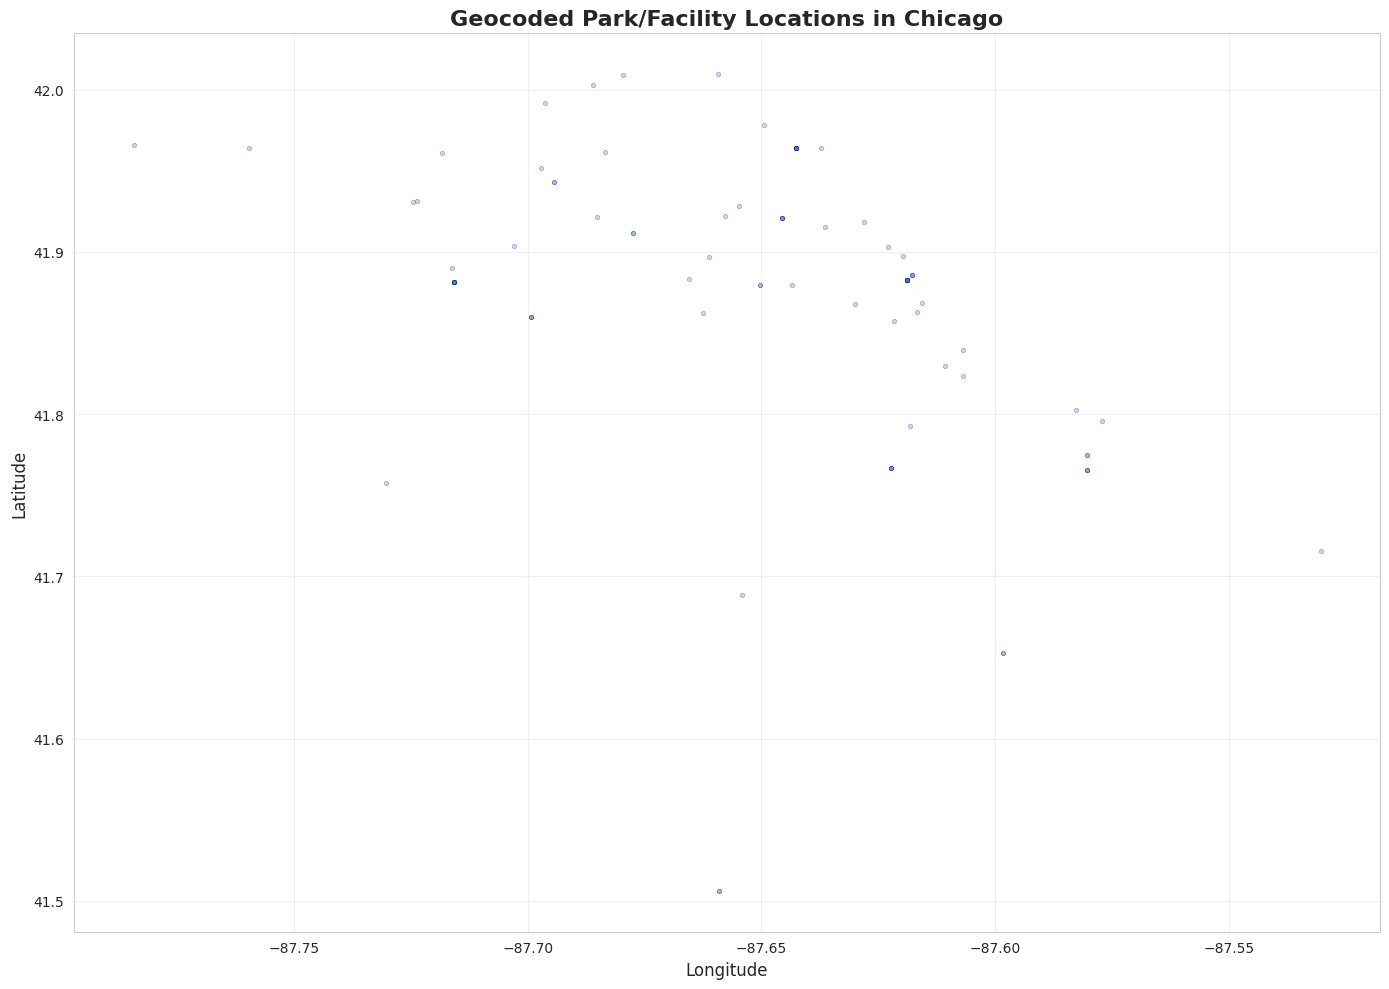

Coordinate Statistics:
Latitude range: 41.506118 to 42.009575
Longitude range: -87.784371 to -87.530310


In [20]:
# Visualize distribution of geocoded locations on a map (if we have enough data)
if df['Latitude'].notna().sum() > 0:
    plt.figure(figsize=(14, 10))
    
    # Scatter plot of all geocoded locations
    df_coords = df[df['Latitude'].notna()].copy()
    
    plt.scatter(df_coords['Longitude'], df_coords['Latitude'], 
                alpha=0.3, s=10, c='steelblue', edgecolors='darkblue', linewidth=0.5)
    
    plt.title('Geocoded Park/Facility Locations in Chicago', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Show coordinate statistics
    print("Coordinate Statistics:")
    print(f"Latitude range: {df_coords['Latitude'].min():.6f} to {df_coords['Latitude'].max():.6f}")
    print(f"Longitude range: {df_coords['Longitude'].min():.6f} to {df_coords['Longitude'].max():.6f}")


## 4. Save the Enhanced Dataset


In [ ]:
# Save the dataset with latitude, longitude, geocoding query, and method
if not USE_SAMPLE_MODE:
    output_file = '../Chicago_Park_District_-_Event_Permits_Geocoded.csv'
    df.to_csv(output_file, index=False)
    
    print(f"Enhanced dataset saved to: {output_file}")
    print(f"\nDataset shape: {df.shape}")
    print(f"New columns added: Latitude, Longitude, Geocoding Query, Geocoding Method")
    print(f"\nRows with coordinates: {df['Latitude'].notna().sum()} ({df['Latitude'].notna().sum()/len(df)*100:.2f}%)")
    print(f"\nGeocoding Method Summary:")
    print(df['Geocoding Method'].value_counts())
else:
    print("Sample mode: Full dataset save skipped.")
    print("Sample already saved in previous cell.")
    print("To save full dataset, set USE_SAMPLE_MODE = False and re-run.")


In [ ]:
# Save the geocoding mapping for future use (including query and method)
import json

geocoding_mapping = {
    k: {
        'lat': v[0], 
        'lon': v[1], 
        'query': v[2], 
        'method': v[3]
    } 
    for k, v in park_coords.items()
}
with open('../park_facility_coordinates.json', 'w') as f:
    json.dump(geocoding_mapping, f, indent=2)

print("Geocoding mapping saved to: ../park_facility_coordinates.json")
print("Includes: latitude, longitude, geocoding query, and method for each park/facility")


## Summary

1. ✅ Explored the dataset structure and basic statistics
2. ✅ Analyzed Park/Facility name distribution
3. ✅ Analyzed Event Types and Permit Status
4. ✅ Analyzed temporal patterns (by year and month)
5. ✅ Geocoded Park/Facility names to latitude and longitude coordinates
6. ✅ Created enhanced dataset with coordinates
7. ✅ Saved geocoding mapping for future use
